# Getting started with `sbi`

`sbi` provides a simple interface to run state-of-the-art algorithms for simulation-based inference.

**The overall goal of simulation-based inference is to algorithmically identify mechanistic models which are consistent with data.**

In this tutorial we demonstrate how to get started with the `sbi` toolbox and how to perform parameter inference on a simple model. 

Each of the implemented inference methods needs three inputs: 
1. A candidate (mechanistic) model - _the simulator_
2. prior knowledge or constraints on model parameters - _the prior_
3. observational data (or summary statistics thereof) - _the observations_

Note, you can find the original version of this notebook at [https://github.com/sbi-dev/sbi/blob/main/tutorials/00_getting_started.ipynb](https://github.com/sbi-dev/sbi/blob/main/tutorials/00_getting_started.ipynb) in the `sbi` repository.

In [6]:
import torch

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

## Parameter inference in a linear Gaussian example



For this illustrative example, we consider a model _simulator_, that takes in 3 parameters (theta). For simplicity, the _simulator_ outputs simulations of the same dimensionality and just adds 1.0 and some Gaussian noise to the parameter set. 

For the 3-dimensional parameter space we consider a uniform _prior_ between [-2,2].

> Note: This is where you would incorporate prior knowlegde about the parameters you want to learn the distribution over. 



In [5]:
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

def simulator(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1

We have to ensure that your _simulator_ and _prior_ adhere to the requirements of `sbi`. You can do so with the `process_simulator()` and `process_prior()` functions, which prepare them appropriately. Finally, you can call `check_sbi_input()` to make sure they are consistent which each other.

In [7]:
# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

Next, we instantiate the inference object. Here, we use Sequential Neural Posterior Estimation (SNPE):

In [8]:
inference = SNPE(prior=prior)

Next, we generate simulations or more specifically generate pairs of paramters $\theta$ which we sample from the _prior_ and correpsonding simulations $x = \mathrm{simulator} (\theta)$ . 

You can do so either by yourself by sampling from the prior and running the simulator (e.g., on a compute cluster), or you can use a helper function provided by `sbi` called `simulate_for_sbi`. This function allows to parallelize your code with `joblib`.

In [9]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=2000)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

We then pass the simulated data to the inference object. Both `theta` and `x` should be a `torch.Tensor` of type `float32`.

In [10]:
inference = inference.append_simulations(theta, x)

Next, we train the _neural density estimator_ to learn the (probabilistic) association between the simulated data (or data features) and the underlying parameters:

In [11]:
density_estimator = inference.train()

 Neural network successfully converged after 56 epochs.

Finally, we use this _density estimator_ to build the posterior distribution $p(\theta|x)$, i.e., the distributions over paramters $\theta$ given observation $x$. Effectively `build_posterior` acts as a wrapper for the raw _density estimator_ that among other features (which go beyond the scope of this introductory tutorial) allows us to sample from the posterior via `.sample()` or generate a pairplot for visualisation via `.pairplot()`.

In [12]:
posterior = inference.build_posterior(density_estimator)

## Visualisations of the inferred posterior for a new observation

Let's say we have made some observation $x_{obs}$ for which we now want to infer the posterior:

In [43]:
x_obs = torch.zeros(3)

 Given this observation, we can then sample from the posterior $p(\theta|x_{obs})$ and visualise the univariate and pairwise marginals for the three parameters.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

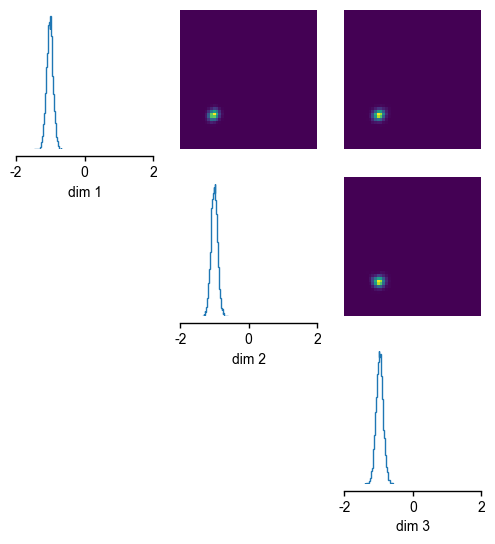

In [44]:
samples = posterior.sample((10000,), x=x_obs)
_ = analysis.pairplot(samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(6, 6))

## Assessing the posterior for a known $\theta, x$ - pair 

In [62]:
theta_true, x_true = simulate_for_sbi(simulator, proposal=prior, num_simulations=1)
theta_off, x_off = simulate_for_sbi(simulator, proposal=prior, num_simulations=1)

Now we can assess, if the interred distirbutions over the parameters match the parameters we used to generate our test sample.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

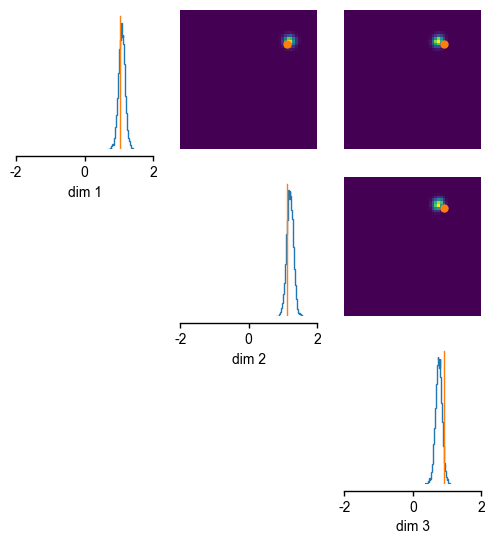

In [63]:
samples = posterior.sample((10000,), x=x_true)
_ = analysis.pairplot(samples, points=theta_true, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(6, 6))

We can evaluate the log-probabilty of the posterior via `.log_prob()`, i.e. we can evaluate the likelihood of parameters $\theta$ given an observation $x$. 

In [66]:
log_probability_true_theta = posterior.log_prob(theta_true, x=x_true)
log_probability_diff_theta = posterior.log_prob(theta_off, x=x_true)
log_probability_samples = posterior.log_prob(samples, x=x_true)

print( r'high for true theta :', log_probability_true_theta)
print( r'low for different theta :', log_probability_diff_theta)
print( r'range of posterior samples: min:', torch.min(log_probability_samples),' max :', torch.max(log_probability_samples))


high for true theta : tensor([2.0262])
low for different theta : tensor([-130.2933])
range of posterior samples: min: tensor(-7.3961)  max : tensor(4.2881)


## Next steps

# TODO